# PhotoFiTT: Pre-mitotic rounding analysis

- Before using this notebook make sure that you have the following: 
  - Pre-mitotic rounding instance segmentation masks: Processed videos using StarDist or any other segmentation method to identify cells in the premitotic rounding. It expects `.tif` video files with the instance mask of each identified cell (*i.e.*, the mask of each cell has a different value).
  - A CSV file indicating the total number of cells in each video. See the notebook `Total cell number.ipynb`.

- The segmentation data is assumed to be organised in folders as follows. Each hierarchical level in the data is encoded as `"Subcategory-XX"` and these names will be used to plot and analyse the data. Alternatively, one could rename these columns.
- The labels in the categories will be identical to the folder name, so the same conditions should always have the same folder name.

   ```
   general_path:
    -Masks (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcaegory-00]
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Ligth / WL 475 light [Subcategory-01]
        ...
   ```

## 0. Import all the required dependencies

In [27]:
import photofitt
from photofitt.analysis import count_mitosis_all, quantify_peaks, compare_peaks, total_cell_number, add_inferred_nuclei
from photofitt import display
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 0.1 Provide some input information
- `masks_path`: The path where the Raw-images are saved. For example "/home/ocb/HardDrive_4TB/PHX/SYNCHRO/Raw-images"
- `output_path`: The path where the notebook will save all the results. Once the cell activity is calculated, a CSV file together with the plots will be stored there.
- `cellnumber_path`: The path where all the cells in the the first frame of each video are segmented. This is needed to calculate the total number of cells in the field of view.
- `frame_rate`: The time frame in the videos given in minutes (e.g., `frame_rate = 4`)

In [28]:
masks_path = "/home/ocb/HardDrive_4TB/EGM/PHX/DATA/MASKS/SYNCHRO/scaled_1.5709_results/stardist_prob03"
output_path =  "/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/premitotic-rounding"
cellnumber_path = "/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/premitotic-rounding"
frame_rate = 4 # The time gap we will use to compute all the metrics

# Create the folders to store the results
os.makedirs(output_path, exist_ok=True)
os.makedirs(os.path.join(output_path, "plots"), exist_ok=True)

## 1. Count the number of mitoses

In [ ]:
data = count_mitosis_all(masks_path, frame_rate = frame_rate)
# save the information
data.to_csv(os.path.join(output_path, "mitosis_counting.csv"))
print(f"A CSV file with the information about detected pre-mitotic rounding is stored in:")
print(f"{os.path.join(path2results, "mitosis_counting.csv")}")

### 1.0 Add the total number of cells information and normalise the cell counting

In [ ]:
## Count the number of cells on each FOV
cell_number = total_cell_number("/media/ocb/OCB-Data2/PhotoFiTT/PIX2PIX/SINGLE_FRAMES/STARDIST/CHO-SYNCHRO/", type="image")
cell_number.to_csv(os.path.join(output_path, "counting_pix2pix.csv"))
print(f"A CSV file with the number of cells on each FOV is stored in:")
print(f"{os.path.join(path2results, "counting_pix2pix.csv")}")


### 1.1 Cross the data of pre-mitotic detections and the total number of cells to normalise the information

In [ ]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "mitosis_counting.csv"))
updated_data = add_inferred_nuclei(data, cell_number)

# -----
updated_data["Cell percentage"] = updated_data["Number of cells"] / updated_data['cell_counts_stardist']
data_filtered = updated_data.loc[lambda updated_data: updated_data["Cell percentage"] <= 1] # Remove anny potential frame that was not well segmented
data_filtered.to_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
print(f"A CSV file with the normalised number of premitotic rounding events on each FOV is stored in:")
print(f"{os.path.join(path2results, "normalised_mitosis_counting.csv")}")

del updated_data, cell_number, data

### 1.2 Display the results per replica and condition

The next code will create different plots with the raw data considering all the conditions and experimental replicas. Use this to identify errors in the data or biased behaviours. 

By default, it will export the plots as `.png`, but you can also specify the `graph_format='png'` in the function.

All the plots will be saved in:
/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/premitotic-rounding/plots


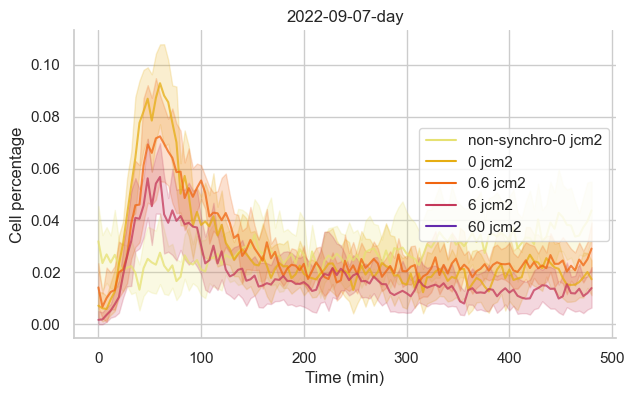

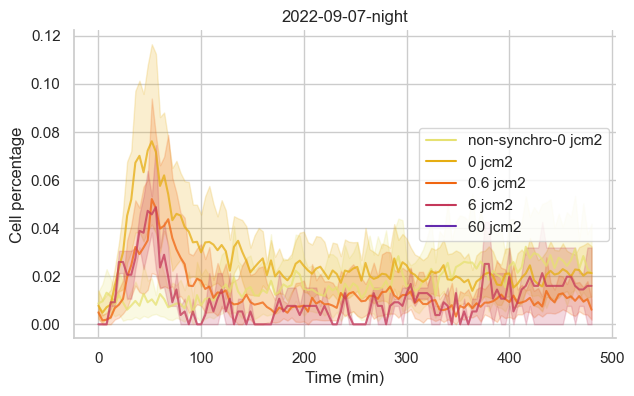

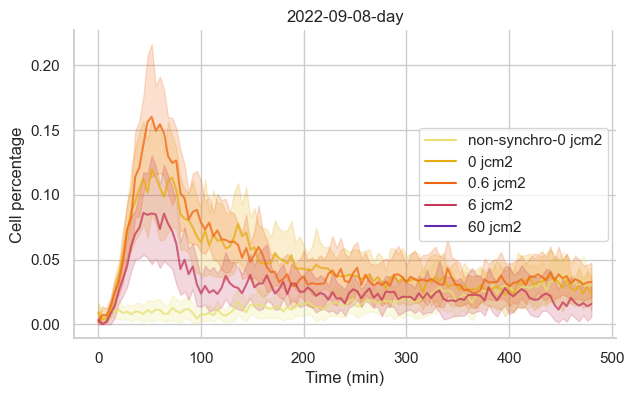

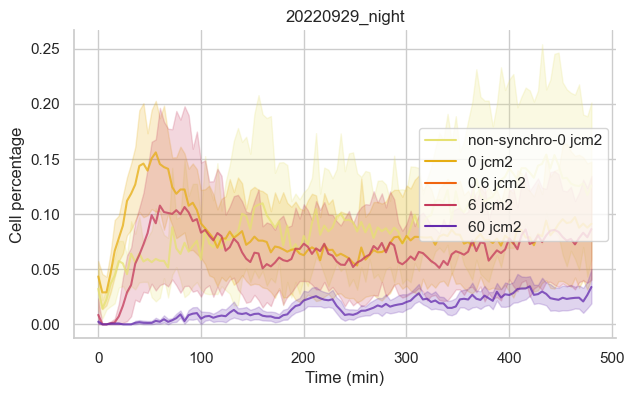

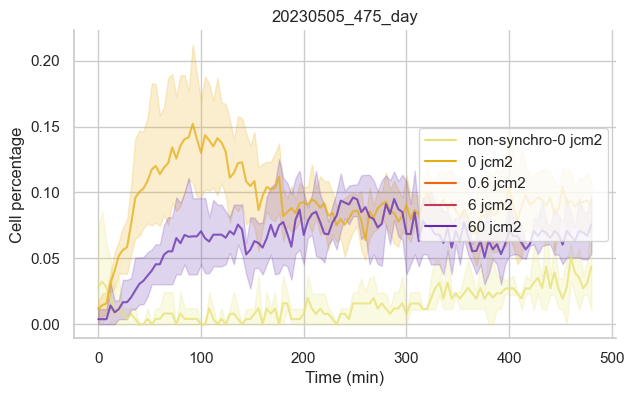

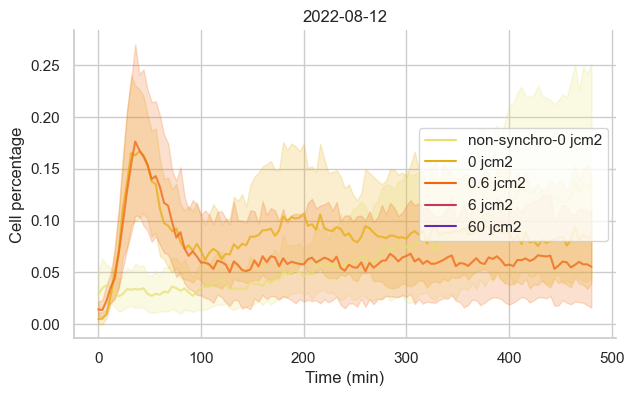

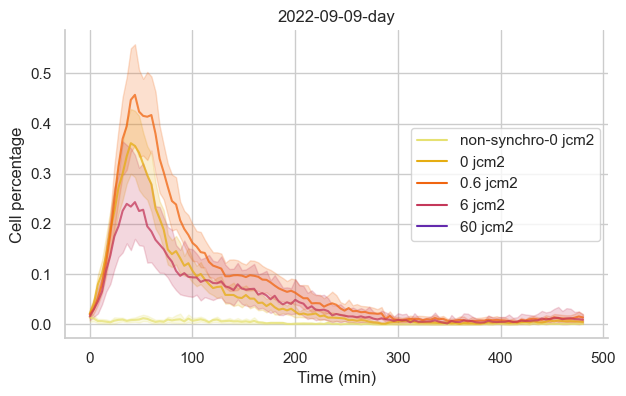

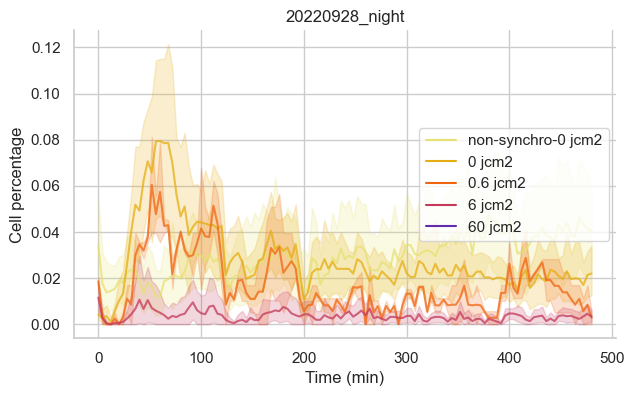

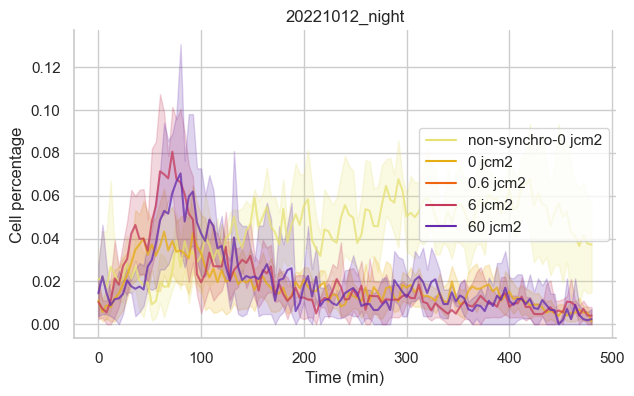

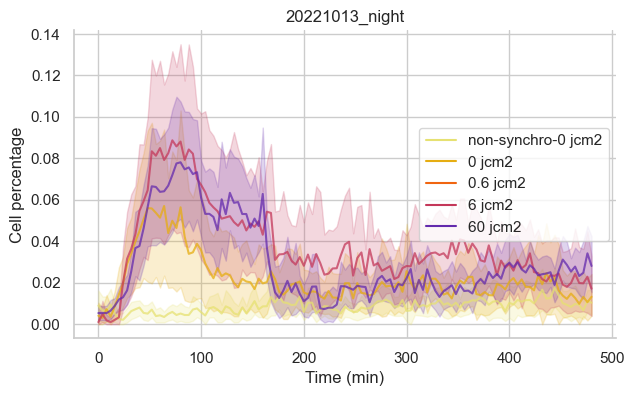

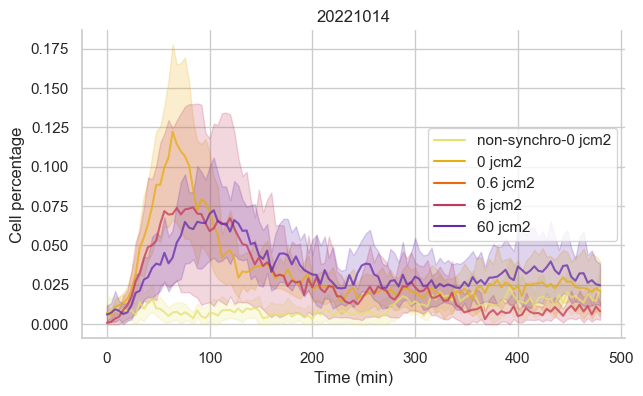

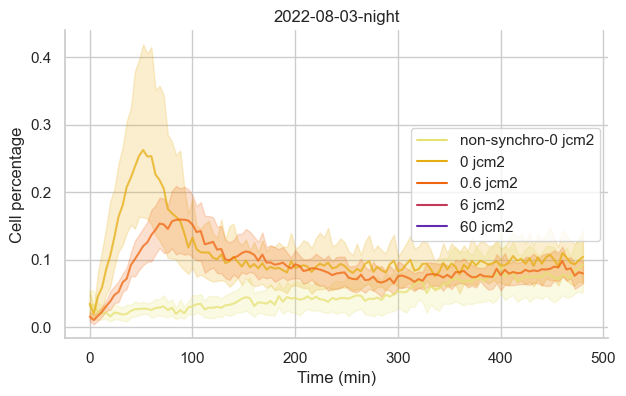

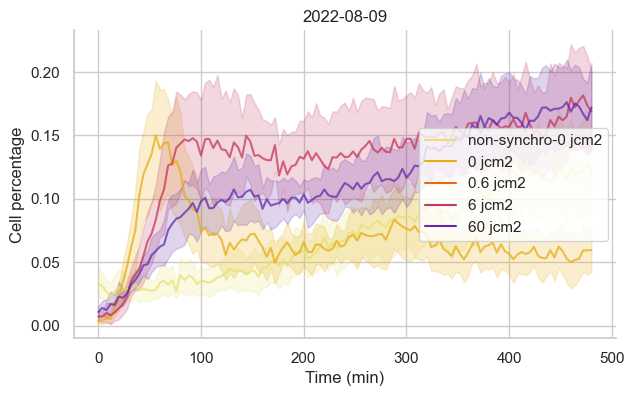

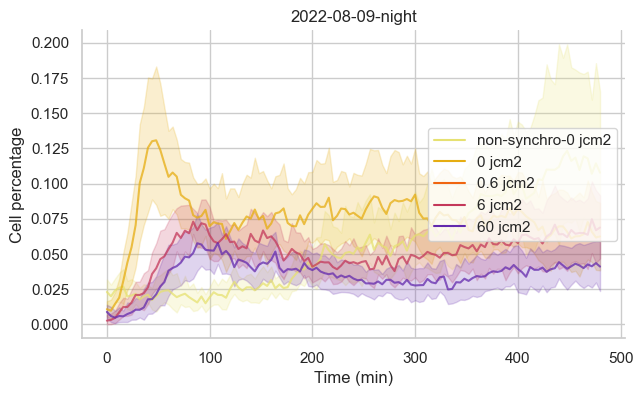

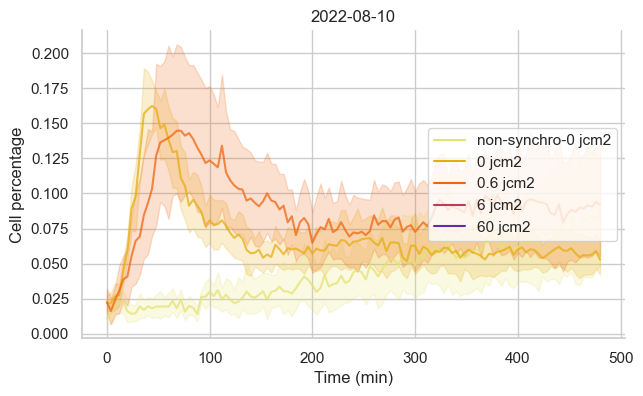

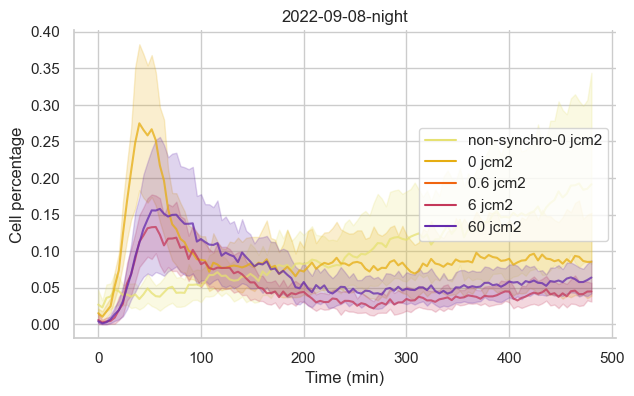

In [30]:
## Load the data
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
wls = np.unique(data["Subcategory-01"])
condition = "Subcategory-02"

## Name of the variable to display in the plot.
plot_y_var = "Cell percentage"
graph_format = ["png"] #, "pdf"]


hue_order = ['non-synchro-0 jcm2', '0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']
print("All the plots will be saved in:")
print(f"{os.path.join(output_path, 'plots')}")

## Colours for the conditions
palette = sns.color_palette("CMRmap_r", len(hue_order)+1) 

for w in wls:
    data_wl = data.loc[lambda data: data["Subcategory-01"]==w]
    groups = np.unique(data_wl["Subcategory-00"])
    for g in groups:
        ploting_data_g = data_wl[data_wl["Subcategory-00"]==g].reset_index(drop=True)  
        for s in ['Raw']:
            ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
            title = f"{g}"
            for f in graph_format:
                name = "Synchro_{0}_{1}_{2}_{3}.{4}".format(w, g, plot_y_var, s, f)
                display.conditions(ploting_data,
                                   plot_y_var,
                                   title,
                                   condition,
                                   os.path.join(output_path, "plots"),
                                   name,
                                   hue_order=hue_order_synchro,
                                   palette=palette)


### 1.3 Display the results for each single wavelength, including all the conditions. Together and separated.

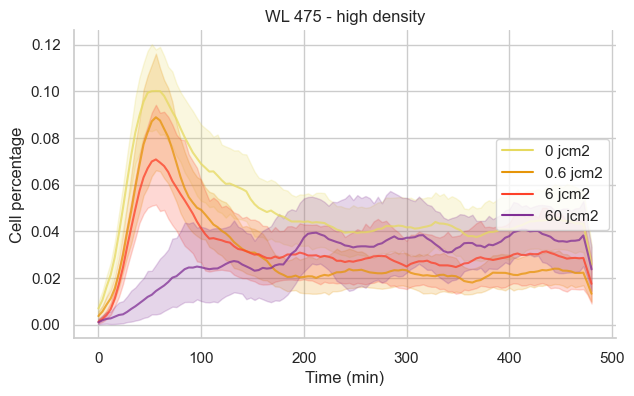

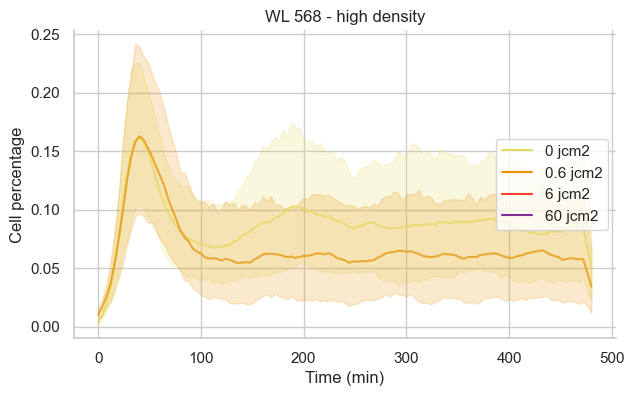

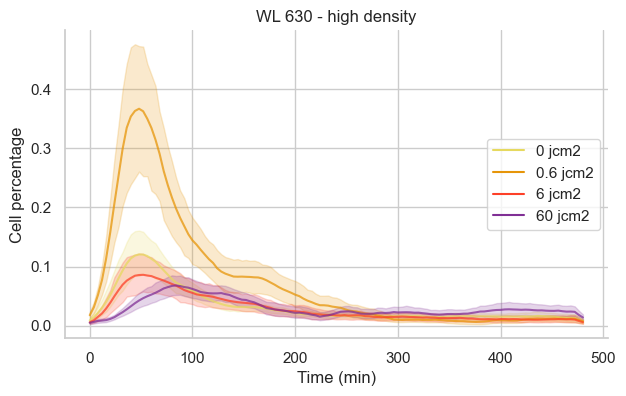

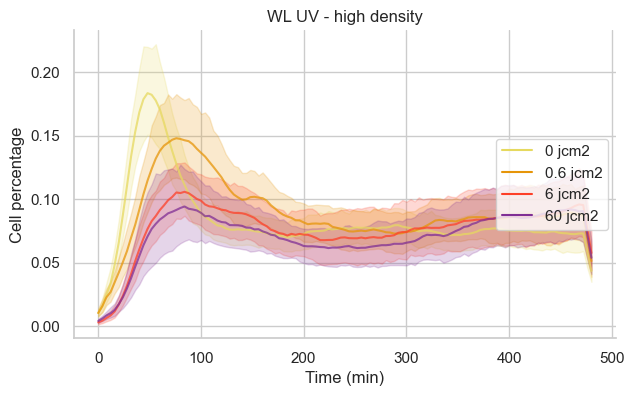

In [33]:
## Indicate the variabled encoding the Wavelength ("Subcategory-01") and light doses ("Subcategory-02").
wls = np.unique(data["Subcategory-01"])
condition = "Subcategory-02"
hue_order = ['0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']

## There is raw and smooth data. We show the smooth data (with a moving average of kernel 5) for the plots.
smoothing = np.unique(data["processing"])

## Name of the variable to display in the plot.
plot_y_var = "Cell percentage"

## Format to save the plots.
graph_format = ["png"] # "pdf"

## Colours for the conditions
palette = sns.color_palette("CMRmap_r", len(hue_order)+1) # we add one to keep the same ones as before where the unsynchronised control was shown.
for w in wls:
    ploting_data_g = data[data["Subcategory-01"]==w].reset_index(drop=True)  
    
    for s in smoothing:
        # sns.set_style()
        ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
        title = f"{w}"
        
        for f in graph_format:
            name = "reduced_{0}_{1}_{2}.{3}".format(w, plot_y_var, s, f)
            display.conditions(ploting_data,
                               plot_y_var,
                               title, condition,
                               os.path.join(output_path, "plots"),
                               name,
                               hue_order=hue_order,
                               palette=palette)


## 2. Calculate the time point with the peak of identified pre-mitotic rounding events

### 2.2. Estimate the mitotic peak and the delay for each video.

In [37]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
# Only the smooth data is used here to reduce the impact of outliers and noise in the detections.
data = data.loc[lambda data: data["processing"]=='Averaged-kernel5']
# Indicate the variable for which the peak is estimated
plot_y_var = "Cell percentage"
# Quantify temporal peaks of mitosis
data_peaks = quantify_peaks(data,
                            plot_y_var,
                            reference_category='0 jcm2',
                            reference_variable="Subcategory-02",)



## Rename the columns to get the proper naming in the plots
data_peaks = data_peaks.rename(columns={'peak_time': 'Pre-mitotic rounding timepoint (min)', 
                            'delay_synchro': 'Delay w.r.t. synchronised cells (min)',
                           'proportional_delay_synchro': 'Proportional delay w.r.t. synchronised cells'})

#### 2.2.1. Plot the distributions with violin plots

<Figure size 640x480 with 0 Axes>

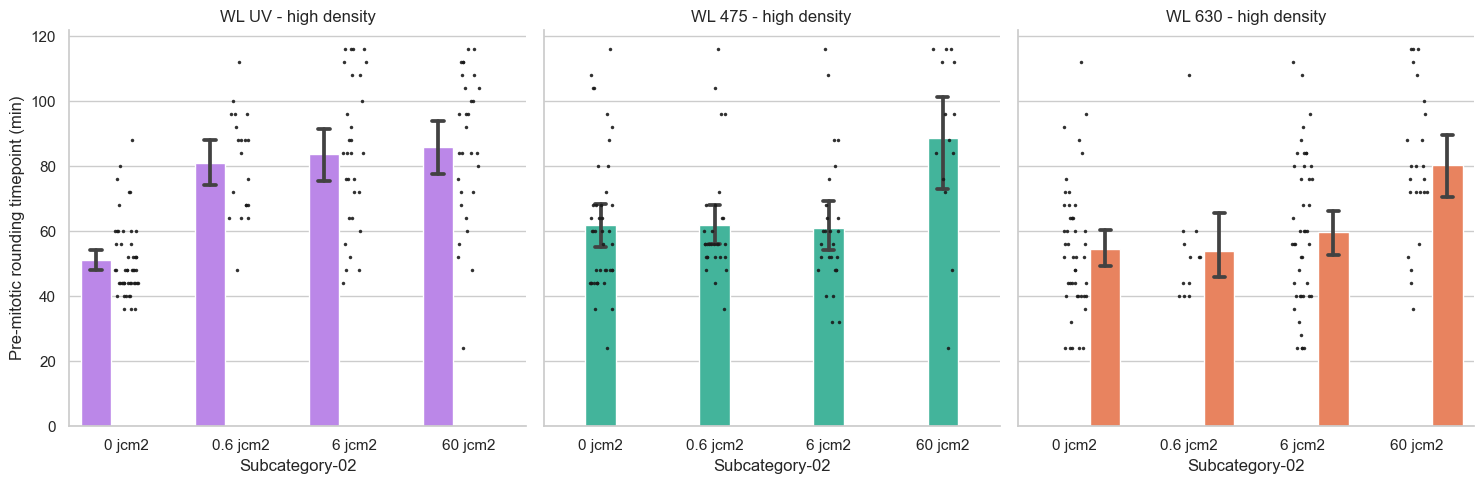

The plots are stored in:
/Users/esti/Documents/PROYECTOS/PHX/PhotoFiTT/example-data/premitotic-rounding/plots


In [40]:
x = 'Pre-mitotic rounding timepoint (min)'
graph_format = ["png"] # "pdf"
condition_var = "Subcategory-02"
hue_order = ['0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']

columns = "Subcategory-01"
wl_order = ['WL UV - high density', 'WL 475 - high density', 'WL 630 - high density']
palette_colours_columns = ['#BC77F8', '#30C7A6', '#FF7848']

for f in graph_format:        
    # Plot all barplots together
    name = f"{x}.{f}"# name we want to give to the plot
    new_name = f"barplot_all_{name}"
    
    fig = plt.figure()
    g = sns.catplot(
        data_peaks, kind="bar",
        x=condition_var, y=x,
        col=columns,
        hue=columns,
        hue_order = wl_order,
        palette=palette_colours_columns,
        order=hue_order, 
        errorbar=("ci", 95),  capsize=.1,
        col_order=wl_order
    )
    g.map_dataframe(sns.stripplot,
            x=condition_var,
            y=x,
            order=hue_order, 
            jitter=True,
            dodge=False,
            marker='.',
            color="k",
            alpha=0.9)
    g.set_titles("{col_name}")
    g.savefig(os.path.join(output_path, "plots", new_name), format=f, transparent=True)
    plt.show()

print("The plots are stored in:")
print(f"{os.path.join(output_path, 'plots')}")

## 3 Cell size dynamics

Display the changes in the cell size distribution. There are some parameters that may change: 
- `density_ylim`: depending on the number of detections, the densities of the distributions can be higher or lowe. It is set by default as `density_ylim=0.20`
- `time_points`: a list of minutes. One can visualise as many points as desired. We set it to see the pre-mitosis, mitosis and post-mitosis distributions as `time_points = [32, 60, 92, 120]`
- `time_limit`: What is the maximum timing for which these dynamics are displayed. We consider 2 hours enough as to visualise the transitions from mother to daughter (`time_limit = 120`) but this could change depending on the case.
- `reduced_hue`: List of conditions. Use it to display data from a smaller set of conditions.

In [46]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))

# Control the order of the legend and the format to export the plots.
# If the order is unknown, let it as huer_order=None
condition = "Subcategory-02"
hue_order = ['non-synchro-0 jcm2', '0 jcm2', '0.6 jcm2', '6 jcm2', '60 jcm2']
colours = ["#BC77F8", "#99E3D7", "#FC9F30", "#FF4126"]

# Additional parameters
density_ylim=0.20
time_points = [32, 60, 92, 120]
time_limit = 120
reduced_hue = ['0 jcm2', '0.6 jcm2', '6 jcm2', '60 jcm2']

# Format to store the plots
graph_format = ['png'] # 'pdf'

for g in graph_format:
    display_data_from_masks(data, os.path.join(output_path, "plots"),
                            x_var ="Subcategory-02",
                            x_label = "Light dose [J/cm2]",
                            graph_format=g,
                            hue_order=hue_order,
                            palette="cool",
                            reduced_hue=reduced_hue,
                            common_norm=False,
                            time_limit=time_limit,
                            time_points=time_points,
                            time_colours=colours,
                            orient="h",
                            density_ylim=density_ylim,
                            xlim=50)
print("All the new cell size data generated as well as the plots are stored in:")
print(f"{os.path.join(output_path, 'plots')}")

WL 475 - high density


ValueError: Could not interpret input 'Subcategory-02'

<Figure size 500x700 with 0 Axes>